--- 
description: Here we show how to solve directed feedback vertex set problem using JijZept and JijModeling.
---

# Directed Feedback Vertex Set problem

Here we show how to solve directed feedback vertex set problem using JijZept and [JijModeling](https://www.ref.documentation.jijzept.com/jijmodeling/). 
This problem is also mentioned in 8.3. Directed Feedback Vertex Set on [Lucas, 2014, "Ising formulations of many NP problems"](https://www.frontiersin.org/articles/10.3389/fphy.2014.00005/full).

## What is Directed Feedback Vertex Set problem?

A directed feedback vertex set is a set of vertices in a directed graph $G = (V, E)$ that, if removed, would result in the graph becoming acyclic (i.e., without any directed cycles).
In other words, a feedback vertex set for a directed graph is a subset $F \subset V$ such that the subgraph $(V − F, \partial(V − F ))$ is acyclic (has no cycles). 
We refer to $F$ as the feedback set.
We solve the optimization problem of finding the smallest size of the feedback set.

### Example

Here is an example of a directed graph and its feedback vertex set:
Consider the directed graph $G = (V, E)$ as shown below. 
One feedback vertex set for this graph is $F = \{3\}$, because if we remove vertex 3 from the graph, we are left with the subgraph with vertices as $\{0, 1, 2, 4, 5, 6, 7\}$, which is acyclic.

![](./assets/23-dfv.png)

### The existence of nodes with no edges pointing towards them in directed acyclic graphs

There exists a node in a directed acyclic graph which is not the end point of any edges.
This means that if you follow the direction of the edges, you will never end up at the same node you started from by traversing the edges of the graph.

### Condition for a directed graph

The condition for a directed graph is that there exists a height function $h : V \to N$ (i.e., a function that assigns each vertex a non-negative integer) such that for every edge $uv \in E$, $h(u) < h(v)$. In other words, for any directed edge, the starting vertex has a smaller height than the ending vertex.

## Construction of a mathematical model

First, we introduce binary variables $y_e$ which are 0 if $v$ is part of the feedback set, and 1 otherwise.
Then we place binary variables $x_{v, i}$ which are 1 if vertex $v$ is at height $i$ and 0 otherwise.

### Constraint 1: a vertex has a well-defined height if it is not part of the feedback set

This ensures that if a vertex is not part of the feedback set, it has a well-defined height.

$$
\quad y_v - \sum_ix_{v,i} = 0 \quad  (\forall v) \tag{1}
$$

### Constraint 2: edges only connect nodes from lower to higher height

This ensures that an edge only connects a node with lower height to a node at higher height.

$$
\quad \sum_{uv \in E}\sum_{i \geq j}x_{u,i}x_{v,j} \tag{2}
$$

### Objective function : minimize the size of the feedback set

We set the objective function as follows.

$$
\min \sum_{v}(1-y_v) \tag{3}
$$

## Modeling by JijModeling

Next, we show an implementation using JijModeling. We first define variables for the mathematical model described above.

In [1]:
import jijmodeling as jm

# define variables
V = jm.Placeholder('V')  # number of vertices
E = jm.Placeholder('E', ndim=2)  # set of edges
num_E = E.shape[0]
N = jm.Placeholder('N')  # number of heights

x = jm.BinaryVar('x', shape=(V, N))
y = jm.BinaryVar('y', shape=(V,))

i = jm.Element('i', belong_to=N)  # subscripts for heights
j = jm.Element('j', belong_to=N)  # subscripts for heights
v = jm.Element('v', belong_to=V)
e = jm.Element('e', belong_to=num_E)


### Constraint

We implement the constraint equations.

In [2]:
# set problem
problem = jm.Problem('Directed Feedback Vertex')
# set constraint
problem += jm.Constraint('const1', y[v]-jm.sum(i, x[v,i])==0, forall=v)
problem += jm.Constraint('const2', jm.sum([e,i,(j, i>=j)], x[E[e][0],i]*x[E[e][1],j])==0)

### Objective function

Next, we implement an objective function.

In [3]:
# set objective function: 
problem += jm.sum(v, 1-y[v])

Let's display the implemented mathematical model in Jupyter Notebook.

In [4]:
problem

## Prepare an instance

We prepare a graph using [Networkx](https://networkx.org/), and the graph is the same as the one shown in the example.

In [9]:
import networkx as nx

# set empty graph
inst_G = nx.DiGraph()
# add edges
dir_E = [(0, 1), (0, 2), (1, 3), (2, 3), (3, 4),
         (4, 5), (5, 6), (6, 3), (7, 4)]
inst_G.add_edges_from(dir_E)
# get the number of nodes
inst_V = list(inst_G.nodes)
num_V = len(inst_V)
inst_N = num_V
inst_E = [list(t) for t in dir_E]

instance_data = {'N': inst_N, 'V': num_V, 'E': inst_E}

This graph for clique cover problem is shown below.

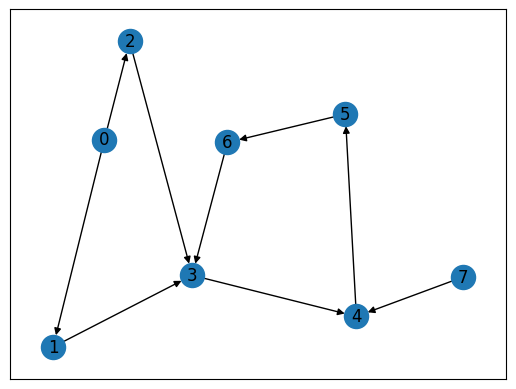

In [10]:
import matplotlib.pyplot as plt

# Compute the layout
pos = nx.spring_layout(inst_G)
nx.draw_networkx(inst_G, pos, with_labels=True)
plt.show()

## Solve by JijZept's SA

We solve this problem using JijZept `JijSASampler`. We also use the parameter search function by setting `search=True`.

In [12]:
import jijzept as jz

# set sampler
sampler = jz.JijSASampler(config="./config.toml")
# solve problem
multipliers = {'const1': 0.5, 'const2': 0.5}
results = sampler.sample_model(problem, instance_data, multipliers, num_reads=100, search=True)

## Visualize solution

In the end, we extract the lowest energy solution from the feasible solutions and visualize it.

Objective: 1.0


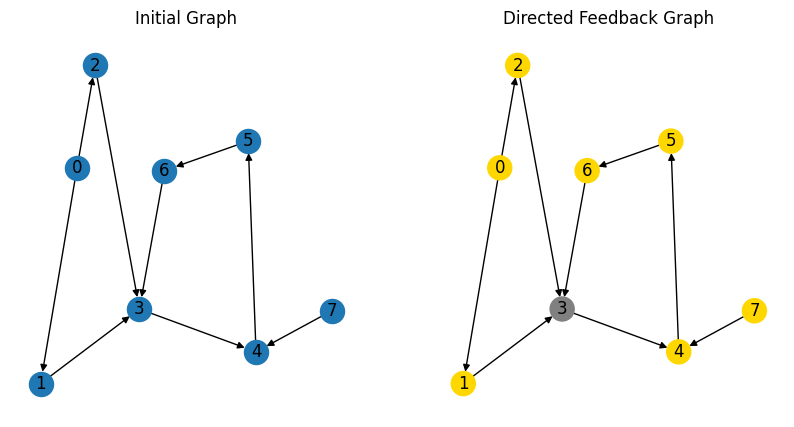

In [13]:
# extract feasible solution
feasible = results.feasible()
if feasible.evaluation.objective.size == 0:
    print('No feasible solution found ...')
else:
    print("Objective: "+str(feasible.evaluation.objective[0]))
    # get indices of x = 1
    indices, _, _ = feasible.record.solution['x'][0]
    # initialize vertex color t ogray
    node_colors = ['gray'] * num_V
    # set selected vertex color to gold 
    for i in indices[0]:
        node_colors[i] = 'gold'

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    # plot the initial graph
    nx.draw_networkx(inst_G, pos=pos, with_labels=True, ax=ax1)
    ax1.set_title('Initial Graph')
    plt.axis('off')
    ax1.set_frame_on(False) # Remove the frame from the first subplot
    # plot the graph
    nx.draw_networkx(inst_G, pos, node_color=node_colors, with_labels=True)
    plt.axis('off')
    ax2.set_title('Directed Feedback Graph')
    plt.show()

As we expected, JijZept successfully finds the smallest size of the feedback set.

Lastly, we will go over the Undirected Feedback Vertex Set problem and the Feedback Edge Set problem.
The Undirected Feedback Vertex Set problem can be stated as follows: given an undirected graph, find the smallest subset of vertices whose removal results in an acyclic graph.
This problem is actually extremely similar to minimal spanning tree, but without degree constraints or connectivity constraints. The new subtlety, however, is that we cannot remove edges.
The Feedback Edge Set problem is a similar problem for directed graphs: given a directed graph, find the smallest subset of edges whose removal results in a directed acyclic graph.
Our solution will be somewhat similar to the directed feedback vertex set.